In [1]:
import pandas as pd
import numpy as np

# 한글 깨짐 방지
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'malgun Gothic'

# 경고창 무시 
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import FinanceDataReader as fdr
from pykrx import stock
import datetime

In [2]:
# 데이터로드
df = pd.read_csv('./datasets/투자/KOSDAQ+KOSPI_DATA(투자).csv', index_col=0)
# 상장일 데이터 로드 후 회사명기준으로 중복 데이터 삭제
df1 = pd.read_csv('./datasets/상장일.csv', encoding='cp949')
df1 = df1[['거래소코드', '상장일']]
df1.drop_duplicates('거래소코드', inplace=True)
# 데이터 결합
df2 = pd.merge(df, df1, how='left', on='거래소코드')
# 회계년도, 상장일 년도만 추출
df2['회계년도추출'] = pd.to_datetime(df2['회계년도'], format=('%Y/%m')).dt.strftime('%Y')
df2['상장일추출'] = pd.to_datetime(df2['상장일'], format=('%Y/%m/%d')).dt.strftime('%Y')
# 회계년도가 상장일보다 큰 기업만 추출
df = df2[df2['회계년도추출'] > df2['상장일추출']].reset_index(drop=True)

In [3]:
df

,회사명,거래소코드,회계년도,총자본증가율,총자본순이익률,자기자본순이익률,매출원가대매출액비율,금융비용대총비용비율,자기자본구성비율,순운전자본비율,CASHFLOW대총자본비율,순운전자본회전률,시가총액,상장일,회계년도추출,상장일추출
0,(주)DB하이텍,990,2016/12,0.217845,8.96,29.65,62.49,5.84,34.65,9.60,20.32,1.26,705448528800,1975/12/12,2016,1975
1,(주)DB하이텍,990,2017/12,0.725788,11.12,27.62,62.70,3.79,45.86,20.97,21.70,1.19,532413984000,1975/12/12,2017,1975
2,(주)DB하이텍,990,2018/12,7.302473,8.43,17.12,67.83,2.26,52.36,21.24,17.04,1.29,481724679800,1975/12/12,2018,1975
3,(주)DB하이텍,990,2019/12,2.096136,9.71,17.40,63.57,1.55,59.20,18.97,15.68,1.36,1225401028800,1975/12/12,2019,1975
4,(주)DB하이텍,990,2020/12,8.236920,14.64,23.07,61.65,0.62,67.42,16.76,19.98,1.37,2264327988000,1975/12/12,2020,1975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11328,흥구석유(주),24060,2012/12,-1.142093,1.91,2.26,96.91,0.05,86.00,8.60,4.12,10.79,23775000000,1994/12/07,2012,1994
11329,흥구석유(주),24060,2016/12,1.387501,2.77,3.17,94.67,0.02,87.41,14.15,3.55,8.24,51375000000,1994/12/07,2016,1994
11330,흥구석유(주),24060,2017/12,0.979314,2.60,2.97,94.93,0.07,87.29,8.68,1.67,7.20,41625000000,1994/12/07,2017,1994
11331,흥구석유(주),24060,2018/12,-5.888978,3.06,3.38,95.00,-0.01,93.67,11.59,4.39,8.08,40575000000,1994/12/07,2018,1994


# BackTesting함수

In [4]:
def change(df, day, year, number):
    흑자기업_df = df[df['회계년도'] == day]

    # 시가총액을 기준으로 오름차순으로 정렬
    df_sorted = 흑자기업_df.sort_values('시가총액') 
    # 하위 20% 데이터의 개수
    cutoff_index = int(len(df_sorted) * 0.2)
    # 하위 20%의 최소값
    cutoff_value = df_sorted.iloc[cutoff_index]['시가총액'] 
    # 시가총액이 하위 20% 이상인 데이터만 선택
    cutoff_data = df_sorted[df_sorted['시가총액'] >= cutoff_value] 
    # 인덱스초기화
    cutoff_data.reset_index(drop=True, inplace=True)
    # 불필요컬럼삭제
    cutoff_data.drop(columns=['시가총액'], axis=1, inplace=True)

    # 1. 총자본 증가율을 기준으로 오름차순 정렬
    df_sorted = cutoff_data.sort_values(by="총자본증가율", ascending=False)
    # 구간 수
    n_groups = 10
    # 각 구간의 범위 계산
    group_range = len(cutoff_data) // n_groups
    ranges = [(i*group_range, (i+1)*group_range) for i in range(n_groups)]
    ranges[-1] = (ranges[-1][0], len(cutoff_data))
    # 각 구간에 할당할 번호 계산
    groups = [i+1 for i in range(n_groups) for _ in range(ranges[i][0], ranges[i][1])]
    # 결과 출력
    df_sorted["총자본증가율구간"] = groups

    # 2. 총자본순이익률 기준으로 오름차순 정렬
    df_sorted = df_sorted.sort_values(by="총자본순이익률", ascending=False)
    # 각 구간의 범위 계산
    group_range = len(df_sorted) // n_groups
    ranges = [(i*group_range, (i+1)*group_range) for i in range(n_groups)]
    ranges[-1] = (ranges[-1][0], len(df_sorted))
    # 각 구간에 할당할 번호 계산
    groups = [i+1 for i in range(n_groups) for _ in range(ranges[i][0], ranges[i][1])]
    # 결과 출력
    df_sorted["총자본순이익률구간"] = groups

    # 3. 자기자본순이익률을 기준으로 오름차순 정렬
    df_sorted = df_sorted.sort_values(by="자기자본순이익률", ascending=False)
    # 각 구간의 범위 계산
    group_range = len(df_sorted) // n_groups
    ranges = [(i*group_range, (i+1)*group_range) for i in range(n_groups)]
    ranges[-1] = (ranges[-1][0], len(df_sorted))
    # 각 구간에 할당할 번호 계산
    groups = [i+1 for i in range(n_groups) for _ in range(ranges[i][0], ranges[i][1])]
    # 결과 출력
    df_sorted["자기자본순이익률구간"] = groups

    # 4. 매출원가대매출액비율을 기준으로 내림차순 정렬
    df_sorted = df_sorted.sort_values(by="매출원가대매출액비율", ascending=True)
    # 각 구간의 범위 계산
    group_range = len(df_sorted) // n_groups
    ranges = [(i*group_range, (i+1)*group_range) for i in range(n_groups)]
    ranges[-1] = (ranges[-1][0], len(df_sorted))
    # 각 구간에 할당할 번호 계산
    groups = [i+1 for i in range(n_groups) for _ in range(ranges[i][0], ranges[i][1])]
    # 결과 출력
    df_sorted["매출원가대매출액비율구간"] = groups

    # 5. 금융비용대총비용비율을 기준으로 내림차순 정렬
    df_sorted = df_sorted.sort_values(by="금융비용대총비용비율", ascending=True)
    # 각 구간의 범위 계산
    group_range = len(df_sorted) // n_groups
    ranges = [(i*group_range, (i+1)*group_range) for i in range(n_groups)]
    ranges[-1] = (ranges[-1][0], len(df_sorted))
    # 각 구간에 할당할 번호 계산
    groups = [i+1 for i in range(n_groups) for _ in range(ranges[i][0], ranges[i][1])]
    # 결과 출력
    df_sorted["금융비용대총비용비율구간"] = groups

    # 6. 자기자본구성비율
    q25, q75 = np.percentile(df_sorted['자기자본구성비율'], [25, 75])

    def change(x):
        if x < 33.333333:
            return 10
        elif (x < q25 ) & (x >= 33.333333):  
            return 6
        elif (x >= q25) & (x < q75):
            return 1
        elif (x < 100) & (x >= q75):
            return 6
        
    df_sorted['자기자본구성비율구간'] = df_sorted['자기자본구성비율'].apply(change)

    # 7. 순운전자본비율을 기준으로 오름차순 정렬
    df_sorted = df_sorted.sort_values(by="순운전자본비율", ascending=False)
    # 각 구간의 범위 계산
    group_range = len(df_sorted) // n_groups
    ranges = [(i*group_range, (i+1)*group_range) for i in range(n_groups)]
    ranges[-1] = (ranges[-1][0], len(df_sorted))
    # 각 구간에 할당할 번호 계산
    groups = [i+1 for i in range(n_groups) for _ in range(ranges[i][0], ranges[i][1])]
    # 결과 출력
    df_sorted["순운전자본비율구간"] = groups
    
    # 8. CASHFLOW대총자본비율을 기준으로 오름차순 정렬
    df_sorted = df_sorted.sort_values(by="CASHFLOW대총자본비율", ascending=False)
    # 각 구간의 범위 계산
    group_range = len(df_sorted) // n_groups
    ranges = [(i*group_range, (i+1)*group_range) for i in range(n_groups)]
    ranges[-1] = (ranges[-1][0], len(df_sorted))
    # 각 구간에 할당할 번호 계산
    groups = [i+1 for i in range(n_groups) for _ in range(ranges[i][0], ranges[i][1])]
    # 결과 출력
    df_sorted["CASHFLOW대총자본비율구간"] = groups

    # 9. 순운전자본비율을 기준으로 오름차순 정렬
    df_sorted = df_sorted.sort_values(by="순운전자본회전률", ascending=False)
    # 각 구간의 범위 계산
    group_range = len(df_sorted) // n_groups
    ranges = [(i*group_range, (i+1)*group_range) for i in range(n_groups)]
    ranges[-1] = (ranges[-1][0], len(df_sorted))
    # 각 구간에 할당할 번호 계산
    groups = [i+1 for i in range(n_groups) for _ in range(ranges[i][0], ranges[i][1])]
    # 결과 출력
    df_sorted["순운전자본회전률구간"] = groups

    # 순위 9종목 합계
    df_sorted['합계'] = df_sorted.iloc[:, -9:].T.sum()

    # 상위 10개 기업 뽑기
    selection = df_sorted.sort_values('합계').head(number)

    # 상위 10개 기업 점수 평균
    print('기업 평균 점수 :',selection['합계'].mean())
    
    # 종목코드를 6자리로 통일. ex) 990 -> 000990
    def padding(x):
        x = str(x)
        return x.rjust(6, "0")
    
    selection['거래소코드'] = selection['거래소코드'].map(padding)

    상위10종목_list = selection['거래소코드'].tolist()

    # 백테스팅 기간 : 2011.01.01 ~ 2011.12.31
    start = datetime.datetime(year, 1, 1)
    end = datetime.datetime(year, 12, 31)

    kospi_df = fdr.DataReader("KS11", start, end)
    kosdaq_df = fdr.DataReader("KQ11", start, end)
    kospi_df["KOSPI_누적수익률"] = kospi_df["Close"]/kospi_df["Close"][0]
    kospi_df["KOSPI_누적수익률"] = kospi_df["KOSPI_누적수익률"]*100
    kosdaq_df["KOSDAQ_누적수익률"] = kosdaq_df["Close"]/kosdaq_df["Close"][0]
    kosdaq_df["KOSDAQ_누적수익률"] = kosdaq_df["KOSDAQ_누적수익률"]*100

    invest_list = 상위10종목_list
    portfolio = pd.DataFrame()

    # 한글 깨짐 방지
    import matplotlib.pyplot as plt
    plt.rcParams['font.family'] = 'malgun Gothic'

    for i in invest_list:
        portfolio[i] = fdr.DataReader(i, start, end)["Close"]

    for i in invest_list:
        portfolio[i] = portfolio[i]/portfolio[i][0]


    portfolio["Hay_수익률(%)"] = portfolio[invest_list[0]]

    for i in invest_list:
        portfolio["Hay_수익률(%)"] = portfolio[i] + portfolio["Hay_수익률(%)"]
        
    portfolio["Hay_수익률(%)"] = portfolio["Hay_수익률(%)"] - portfolio[invest_list[0]]
    portfolio["Hay_수익률(%)"] = portfolio["Hay_수익률(%)"]/number
    portfolio["Hay_수익률(%)"] = portfolio["Hay_수익률(%)"]*100

    df_plot0 = pd.concat([portfolio, kospi_df, kosdaq_df],axis=1)
    df_plot0.plot(y = ["KOSPI_누적수익률", 'KOSDAQ_누적수익률', "Hay_수익률(%)"], figsize = [10,6], grid = True, color=["yellowgreen", "skyblue", "red"])

    print('기업 수 :', number)
    ### 수익률 비교 코드 ###

    # 일별 수익률
    portfolio['일일수익률'] = portfolio['Hay_수익률(%)'].pct_change()

    # 일별 수익률 평균을 연율화
    portfolio_annual_return = portfolio['일일수익률'].mean() * 252

    # 연율화된 변동성
    portfolio_annual_volatility = portfolio['일일수익률'].std() * 252 ** 0.5

    # 포트폴리오 수익률
    portfolio_return = ((portfolio['Hay_수익률(%)'][-1])-(portfolio['Hay_수익률(%)'][0]))/portfolio['Hay_수익률(%)'][0] * 100
    print('Hay_수익률 :',round(portfolio_return,2))

    ## 코스피 ## 
    kospi_df['Normed Return'] = kospi_df['Close'] /kospi_df.iloc[0]['Close']
    kospi_df['KSTotal'] = kospi_df['Normed Return']*100

    # 일별 수익률
    kospi_df['일일수익률'] = kospi_df['KSTotal'].pct_change()

    # 일별 수익률 평균을 연율화
    kospi_annual_return = kospi_df['일일수익률'].mean() * 252

    # 코스피 수익률
    kospi_return = ((kospi_df['KSTotal'][-1])-(kospi_df['KSTotal'][0]))/kospi_df['KSTotal'][0] * 100
    print('코스피 수익률 :',round(kospi_return,2))

    ### 코스닥 ###
    kosdaq_df['Normed Return'] = kosdaq_df['Close'] /kosdaq_df.iloc[0]['Close']
    kosdaq_df['KQTotal'] = kosdaq_df['Normed Return']*100
    
    # 일별 수익률
    kosdaq_df['일일수익률'] = kosdaq_df['KQTotal'].pct_change()

    # 일별 수익률 평균을 연율화
    kosdaq_annual_return = kosdaq_df['일일수익률'].mean() * 252

    # 코스닥 수익률
    kosdaq_return = ((kosdaq_df['KQTotal'][-1])-(kosdaq_df['KQTotal'][0]))/kosdaq_df['KQTotal'][0] * 100
    print('코스닥 수익률 :',round(kosdaq_return,2))

    # Portfolio - KOSPI 과 비교한 샤프지수
    sharpe_comparison_ks = (portfolio_annual_return - kospi_annual_return) / portfolio_annual_volatility
    print('샤프지수(코스피) :',round(sharpe_comparison_ks,2))

    # Portfolio - KOSDAQ 과 비교한 샤프지수
    sharpe_comparison_kq = (portfolio_annual_return - kosdaq_annual_return) / portfolio_annual_volatility
    print('샤프지수(코스닥) :',round(sharpe_comparison_kq,2))


    # # 포트폴리오의 연평균 수익률 계산
    # portfolio_annual_returns = (1 + portfolio['Hay_수익률(%)'].pct_change().mean()) ** 252 - 1

    # # 코스닥의 연평균 수익률 계산
    # kosdaq_annual_returns = (1 + kosdaq_df['KQTotal'].pct_change().mean()) ** 252 - 1

    # # 포트폴리오와 코스닥 수익률의 차이 계산
    # diff_returns = portfolio_annual_returns - kosdaq_annual_returns

    # # 포트폴리오의 수익률 데이터에서 표준편차 계산
    # portfolio_std = portfolio['Hay_수익률(%)'].pct_change().std()

    # # 샤프레이오 비율 계산
    # sharpe_ratio = diff_returns / portfolio_std

    # print('포트폴리오 연평균 수익률: {:.2%}'.format(portfolio_annual_returns))
    # print('코스닥 연평균 수익률: {:.2%}'.format(kosdaq_annual_returns))
    # print('샤프레이오 비율: {:.2f}'.format(sharpe_ratio))

기업 평균 점수 : 18.7
기업 수 : 10
Hay_수익률 : -2.99
코스피 수익률 : -17.69
코스닥 수익률 : -16.84
샤프지수(코스피) : 0.82
샤프지수(코스닥) : 0.68


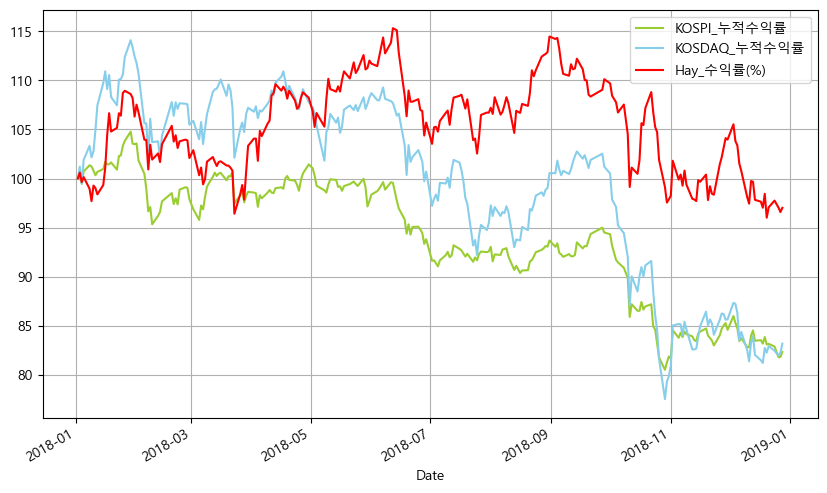

In [42]:
change(df, day='2018/12', year=2018, number=10)

기업 평균 점수 : 20.15
기업 수 : 20
Hay_수익률 : 13.66
코스피 수익률 : -17.69
코스닥 수익률 : -16.84
샤프지수(코스피) : 1.49
샤프지수(코스닥) : 1.35


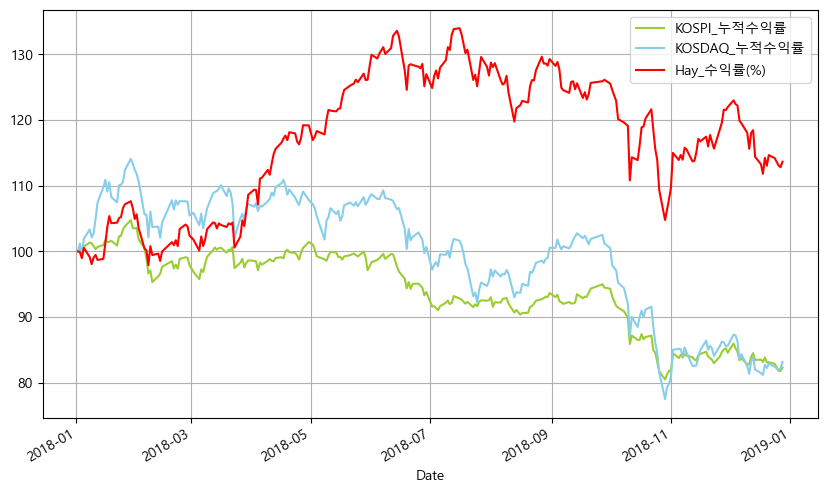

In [43]:
change(df, day='2018/12', year=2018, number=20)

기업 평균 점수 : 20.966666666666665
기업 수 : 30
Hay_수익률 : 1.12
코스피 수익률 : -17.69
코스닥 수익률 : -16.84
샤프지수(코스피) : 1.01
샤프지수(코스닥) : 0.87


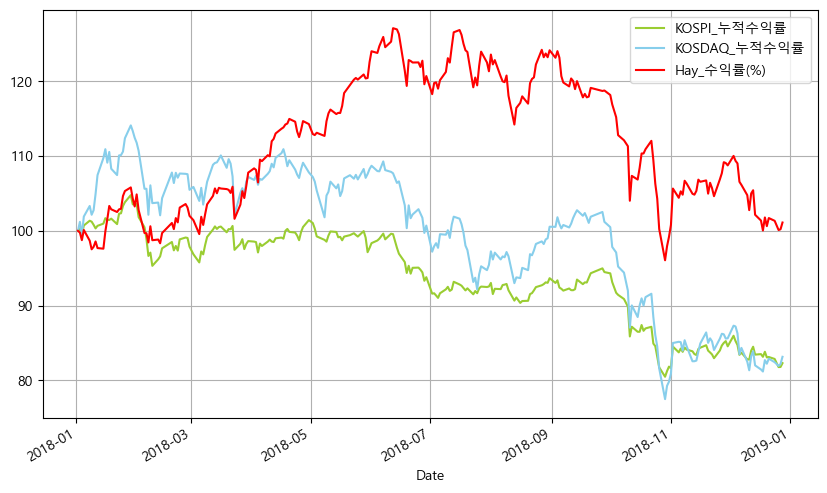

In [44]:
change(df, day='2018/12', year=2018, number=30)